In [2]:
from torch import device
from tensorflow import config, data
from os.path import join
from pathlib import Path
from matplotlib.pyplot import axis, imshow, show, figure, title, subplot, plot, legend
from keras import Sequential
from keras.backend import clear_session
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, RandomFlip, Rescaling, Input
from keras.utils import image_dataset_from_directory
from keras.callbacks import ModelCheckpoint, EarlyStopping
from numpy import argmax
from gc import collect
from git import Repo

device("cpu")
config.set_visible_devices([], 'GPU')

/Users/kiran/Documents/workspace/Projects/algae-detection/src


# Constants

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.3
SEED = 123
ROOT = Repo(".", search_parent_directories = True).working_dir
ALL_PATH = join(".", "algae_ds")#'dataset', 'manually_cleaned_data')
print(ALL_PATH)
CATEGORIES = [ "closterium", "microcystis", "nitzschia", "oscillatoria" ]# sorted([ dir_name for dir_name in listdir(ALL_PATH) if isdir(join(ALL_PATH, dir_name)) ])

# Import dataset

In [5]:
# train_ds, valid_ds = image_dataset_from_directory(ALL_PATH,
#                                                         #color_mode = 'grayscale',
#                                                         subset = 'both',
#                                                         label_mode = 'categorical',
#                                                         validation_split = VALIDATION_SPLIT,
#                                                         seed = SEED,
#                                                         image_size = (IMG_SIZE, IMG_SIZE),
#                                                         batch_size = BATCH_SIZE,
#                                                         shuffle = True
#                                                         )
# count = data.experimental.cardinality(valid_ds)
# test_ds = valid_ds.take(count // 5)
# valid_ds = valid_ds.skip(count // 5)
# TODO Fix how data is taken from `algae_ds`
def get_labels():
    pass

train_ds = image_dataset_from_directory(join(ALL_PATH, "train", "images"),
                                        label_mode = 'categorical',
                                        seed = SEED,
                                        image_size = (IMG_SIZE, IMG_SIZE),
                                        batch_size = BATCH_SIZE,
                                        shuffle = True
                                        )

valid_ds = image_dataset_from_directory(join(ALL_PATH, "valid", "images"),
                                        label_mode = 'categorical',
                                        seed = SEED,
                                        image_size = (IMG_SIZE, IMG_SIZE),
                                        batch_size = BATCH_SIZE,
                                        shuffle = True
                                        )

valid_ds = image_dataset_from_directory(join(ALL_PATH, "test", "images"),
                                        label_mode = 'categorical',
                                        seed = SEED,
                                        image_size = (IMG_SIZE, IMG_SIZE),
                                        batch_size = BATCH_SIZE,
                                        shuffle = True
                                        )

# print('Number of validation batches: %d' % data.experimental.cardinality(valid_ds))
# print('Number of test batches: %d' % data.experimental.cardinality(test_ds))

Found 0 files belonging to 0 classes.


ValueError: No images found in directory /Users/kiran/Documents/workspace/Projects/algae-detection/algae_ds/train/images. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

# Dataset visualization

9 total batches
(64, 224, 224, 3) (64, 5)


2024-04-05 19:00:15.495586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


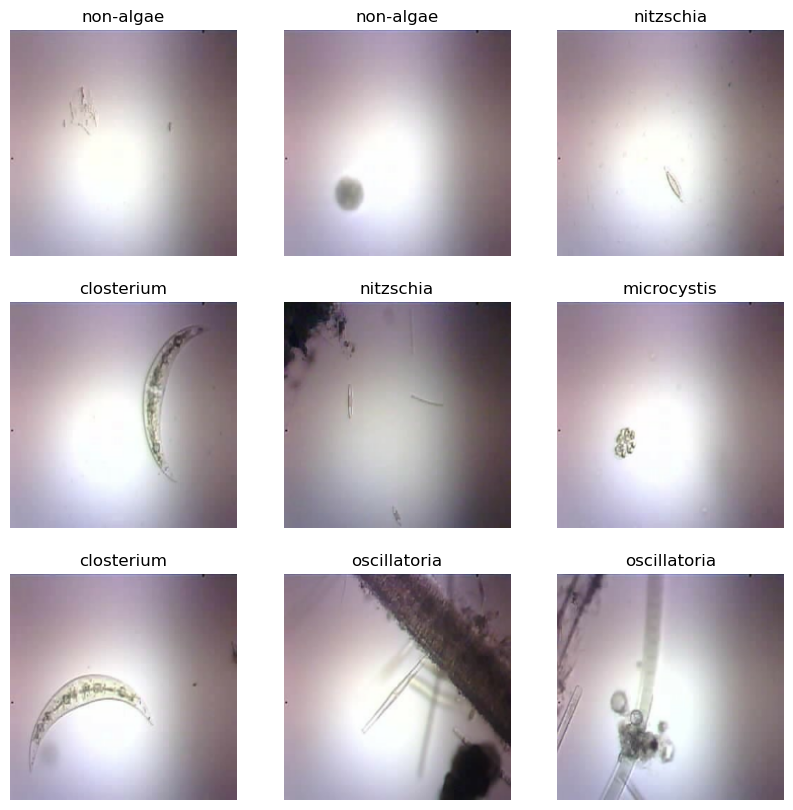

In [5]:
print(len(train_ds), 'total batches')

figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)
    for i in range(9):
        ax = subplot(3, 3, i + 1)
        imshow(images[i].numpy().astype("uint8"))
        title(CATEGORIES[labels[i].numpy().argmax()])
        axis("off")

In [6]:
def reset_keras(model, has_model: bool = True):
    clear_session()
    if has_model: del model
    collect()

In [7]:
model_shape = images.shape[1:]

# Build and compile model

In [8]:
reset_keras(None, False)

# Prefetching samples in GPU memory helps maximize GPU utilization
train_ds = train_ds.shuffle(1000).prefetch(data.AUTOTUNE).cache()
valid_ds = valid_ds.prefetch(data.AUTOTUNE).cache()
test_ds = test_ds.prefetch(data.AUTOTUNE).cache()

def build_model():
  model = Sequential([
    Input(shape = model_shape),# batch_size=images.shape[0]),
    RandomFlip("horizontal_and_vertical", input_shape = model_shape),
    Rescaling(1. / 255),

    Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = "valid", activation = "relu"),
    MaxPooling2D(pool_size = 3, strides = 2),
    BatchNormalization(momentum = 0.9),

    Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = "same", activation = "relu"),
    MaxPooling2D(pool_size = 3, strides = 1),
    BatchNormalization(momentum = 0.9),

    Conv2D(filters = 128, kernel_size = 5, strides = 2, padding = "same", activation = "relu"),
    MaxPooling2D(pool_size = 3, strides = 1),
    BatchNormalization(momentum = 0.9),

    Dropout(0.1),

    Flatten(),

    Dense(1024, activation = "relu"),# input_shape=(prod(image_batch.shape[1:]),)),
    BatchNormalization(momentum = 0.9),

    Dense(1024, activation = "relu"),
    BatchNormalization(momentum = 0.9),
      
    Dense(len(CATEGORIES), activation = "softmax")
  ])

  return model

In [15]:
def compile(model) -> None:
    model.compile(optimizer = Adam(1e-5),
                  loss = CategoricalCrossentropy(from_logits = False),
                  metrics = [ CategoricalAccuracy("accuracy") ]
                 )

# Train model

In [16]:
EPOCHS = 25
VERBOSE = 1
PATIENCE = 20
MONITOR = "val_loss"
MODE = "min"
MODEL_PATH = Path(ROOT / "weights")

EARLY = EarlyStopping(monitor = MONITOR,
                      patience = PATIENCE,
                      verbose = VERBOSE,
                      mode = MODE,
                      restore_best_weights = True
                      )

CHECKPOINT = ModelCheckpoint(join(MODEL_PATH, "model.weights.h5"),
                             monitor = MONITOR,
                             verbose = VERBOSE,
                             save_best_only = True,
                             save_weights_only = True,
                             mode = MODE
                             )

def fit(model):
    return model.fit(train_ds,
                    validation_data = valid_ds,
                    epochs = EPOCHS,
                    verbose = VERBOSE,
                    shuffle = True,
                    callbacks = [ CHECKPOINT, EARLY ]
                    )

model = build_model()
compile(model)

history = fit(model)
model.summary()

Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.2051 - loss: 2.1504
Epoch 1: val_loss improved from inf to 1.74161, saving model to ../model_weights/model.weights.h5
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - accuracy: 0.2084 - loss: 2.1397 - val_accuracy: 0.0987 - val_loss: 1.7416
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.3754 - loss: 1.6616
Epoch 2: val_loss did not improve from 1.74161
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - accuracy: 0.3751 - loss: 1.6632 - val_accuracy: 0.2103 - val_loss: 2.1916
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.4165 - loss: 1.4804
Epoch 3: val_loss did not improve from 1.74161
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.4168 - loss: 1.4818 - val_accuracy: 0.2189 - val_loss: 3.5161
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.4547 - loss: 1.3942
Epoch 4: val_loss did not improve from 1.74161
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - accuracy: 0.4552 - loss: 1.3958 - val_a

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 110, 110, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 27, 27, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │    15,860,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,701,585 (197.23 MB)

 Trainable params: 17,232,325 (65.74 MB)

 Non-trainable params: 4,608 (18.00 KB)

 Optimizer params: 34,464,652 (131.47 MB)

In [ ]:
#model.load_weights(train.latest_checkpoint(MODEL_PATH))
model.save(join(MODEL_PATH, "model_2.h5"))
#model.save_weights(join(MODEL_PATH, "model_weights"))

# Evaluate accuracy

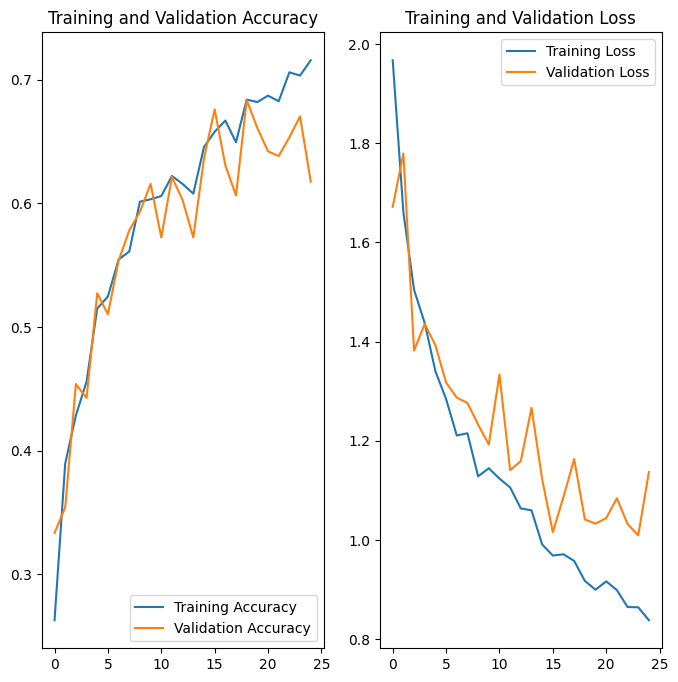

In [18]:
acc, val_acc = history.history["accuracy"], history.history["val_accuracy"]
figure(figsize = (8, 8))
subplot(1, 2, 1)
plot(acc, label = "Training Accuracy")
plot(val_acc, label = "Validation Accuracy")
legend(loc = "lower right")
title("Training and Validation Accuracy")

loss, val_loss = history.history["loss"], history.history["val_loss"]
subplot(1, 2, 2)
plot(loss, label = "Training Loss")
plot(val_loss, label = "Validation Loss")
legend(loc = "upper right")
title("Training and Validation Loss")

show()

# Testing and predicting

In [23]:
model.evaluate(test_ds)
prediction = model.predict(test_ds, verbose = 0)
counter = 0
figure(figsize = (10, 10))

for images, labels in test_ds.take(1):
    for i in range(9):
        predict = CATEGORIES[argmax(prediction[i])]
        correct = CATEGORIES[argmax(labels[i].numpy())]
        img = images[i].numpy().astype("uint8")

        ax = subplot(3, 3, (i) + 1)
        axis("off")
        imshow(img)

        if predict == correct:
            title(predict, fontdict={'color': 'green'})
            counter += 1
        else: title(f"{predict} ({correct})", fontdict={'color': 'red'})

print(f"{counter / 9 * 100:.2f}% of predictions are correct")

2024-04-05 19:20:09.127627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


ValueError: math domain error

In [ ]:
reset_keras(model)